In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-01 10:45:49--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.49.32
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.49.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.7MB/s    in 0.9s    

2022-11-01 10:45:51 (13.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [5]:
# 기온예측문제
import pandas as pd
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
df.head()
# df.shape  (420451, 15)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
import os
fname = os.path.join('/content/jena_climate_2009_2016.csv')
with open(fname) as f:
  data = f.read()

lines = data.split('\n')

In [7]:
header = lines[0].split(',')
lines = lines[1:]

In [8]:
type(header)
type(df.columns.tolist())

list

In [9]:
# 데이터 파싱
import numpy as np
temperature = np.zeros((len(lines)))
raw_data = np.zeros((len(lines), len(header)-1  ))

In [10]:
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i,:] = values[:] 

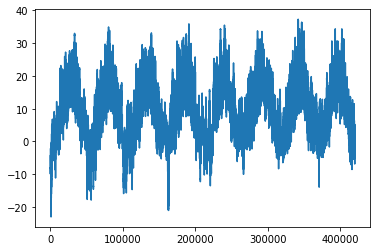

In [11]:
# 전체 기온을 그래프로 그리기
import matplotlib.pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

In [12]:
# 구간을 나눠서 시각화 해보기
6*24*10

1440

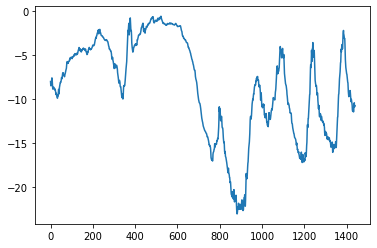

In [13]:
plt.plot(range(1440), temperature[:1440] )
plt.show()

In [14]:
split1 = int(len(raw_data)*0.5)
split2 = int(len(raw_data)*0.25)

train_samples =  raw_data[:split1]
val_samples = raw_data[split1:split1+split2]
test_samples = raw_data[split1+split2:]

In [15]:
len(raw_data)

420451

In [16]:
len(train_samples) , len(val_samples) , len(test_samples)

(210225, 105112, 105114)

In [17]:
# 데이터 정규화 train data
import copy
raw_data2 = copy.deepcopy(raw_data)
mean = train_samples.mean()
raw_data2 -= mean
std = train_samples.std()
raw_data2 /= std

In [18]:
from tensorflow import keras

In [19]:
int_sequence = np.arange(10)
int_sequence

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size=2,
)

In [21]:
int_sequence[:-3],int_sequence[3:]

(array([0, 1, 2, 3, 4, 5, 6]), array([3, 4, 5, 6, 7, 8, 9]))

In [22]:
for inputs,targets in  dummy_dataset:
  print(inputs, targets)


tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int64) tf.Tensor([3 4], shape=(2,), dtype=int64)
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int64) tf.Tensor([5 6], shape=(2,), dtype=int64)
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64) tf.Tensor([7], shape=(1,), dtype=int64)


In [23]:
# 훈련,검증,테스트 데이터셋 만들기
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length+24-1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data2[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle = True,
    batch_size = batch_size,
    sequence_length = sequence_length,
    start_index = 0,
    end_index = split1
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data2[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle = True,
    batch_size = batch_size,
    sequence_length = sequence_length,
    start_index = split1,
    end_index = split1+split2
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data2[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle = True,
    batch_size = batch_size,
    sequence_length = sequence_length,
    start_index = split1+split2    
)

In [24]:
for samples, targets in train_dataset:
  print(samples.shape, targets.shape)
  break


(256, 120, 14) (256,)


In [25]:
# 기준 모델의 MAE 계산하기
def evalute_native_method(dataset):
  total_abs_err = 0.
  samples_seen = 0.
  for samples, targets in dataset:
    preds = samples[:,-1,1]*std  + mean
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

In [26]:
std

380.6416752928181

In [27]:
print(f"검증 MAE :{evalute_native_method(val_dataset  )}")
print(f"테스트 MAE :{evalute_native_method(test_dataset  )}")

검증 MAE :2.4417357485655153
테스트 MAE :2.621898451761205


In [28]:
# 기본적인 머신러닝 모델 적용
# Dense층 연결모델 훈련하고 평가

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

In [30]:
from pyparsing import actions
inputs = keras.Input(shape=(sequence_length, raw_data2.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16,activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense_keras', save_best_only=True)
]

In [32]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])

In [33]:
history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 46s 53ms/step - loss: 46.3169 - mae: 5.3592 - val_loss: 21.3295 - val_mae: 3.6597
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 26.3009 - mae: 4.0344 - val_loss: 24.0593 - val_mae: 3.8881
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 24.5506 - mae: 3.9019 - val_loss: 16.5540 - val_mae: 3.2396
Epoch 4/10
819/819 [==============================] - 43s 53ms/step - loss: 23.4055 - mae: 3.8065 - val_loss: 22.5895 - val_mae: 3.8462
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 22.6528 - mae: 3.7467 - val_loss: 16.6800 - val_mae: 3.2679
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 21.9720 - mae: 3.6897 - val_loss: 17.0393 - val_mae: 3.2607
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 21.3858 - mae: 3.6428 - val_loss: 14.9351 - val_mae: 3.0764
Epoch 8/10
819/819 [============================

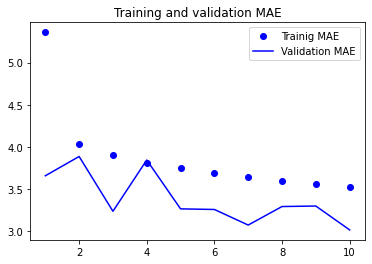

In [34]:
# 결과를 그래프로 그리기
import matplotlib.pyplot as plt
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label='Trainig MAE'  )
plt.plot(epochs, val_loss, "b", label='Validation MAE'  )
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [35]:
# 1D 합성곱 모델 시도
raw_data2.shape

(420451, 14)

In [39]:
sequence_length, raw_data2.shape[-1]

(120, 14)

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data2.shape[-1]))
x = layers.Conv1D(8,14, activation = 'relu')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8,7, activation = 'relu')(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8,3, activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callback = [
    keras.callbacks.ModelCheckpoint('jena_conv.keras', save_best_only=True)
]
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callback)

Epoch 1/10
819/819 [==============================] - 53s 57ms/step - loss: 49.0847 - mae: 5.4812 - val_loss: 31.1398 - val_mae: 4.3761
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 28.5753 - mae: 4.2404 - val_loss: 25.6096 - val_mae: 4.0962
Epoch 3/10
819/819 [==============================] - 45s 54ms/step - loss: 27.3655 - mae: 4.1625 - val_loss: 25.9109 - val_mae: 3.9858
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 26.7642 - mae: 4.1184 - val_loss: 26.9680 - val_mae: 4.0684
Epoch 5/10
819/819 [==============================] - 44s 54ms/step - loss: 26.4113 - mae: 4.0932 - val_loss: 28.0318 - val_mae: 4.3051
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 26.0752 - mae: 4.0702 - val_loss: 24.0007 - val_mae: 3.9272
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 25.8663 - mae: 4.0506 - val_loss: 21.8644 - val_mae: 3.7116
Epoch 8/10
819/819 [============================

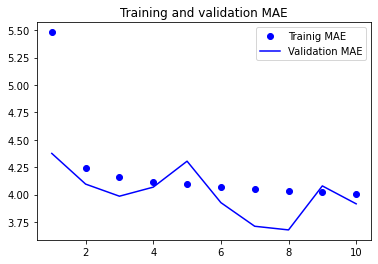

In [41]:
import matplotlib.pyplot as plt
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label='Trainig MAE'  )
plt.plot(epochs, val_loss, "b", label='Validation MAE'  )
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [42]:
from tensorflow.python import metrics
# 순환신경망
# LSTM 기반 신경망
inputs =keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callback = [
    keras.callbacks.ModelCheckpoint('jen_lstm.keras',save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callback)

Epoch 1/10
819/819 [==============================] - 52s 59ms/step - loss: 67.7870 - mae: 6.4871 - val_loss: 30.5055 - val_mae: 4.3332
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 32.5438 - mae: 4.4933 - val_loss: 31.6633 - val_mae: 4.4234
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 28.2457 - mae: 4.2005 - val_loss: 41.7228 - val_mae: 5.2359
Epoch 4/10
819/819 [==============================] - 47s 58ms/step - loss: 24.6858 - mae: 3.9260 - val_loss: 20.5910 - val_mae: 3.5069
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 22.8054 - mae: 3.7526 - val_loss: 17.8174 - val_mae: 3.2590
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 21.4463 - mae: 3.6389 - val_loss: 18.0949 - val_mae: 3.3049
Epoch 7/10
819/819 [==============================] - 66s 80ms/step - loss: 19.1155 - mae: 3.4594 - val_loss: 21.0685 - val_mae: 3.6509
Epoch 8/10
819/819 [============================

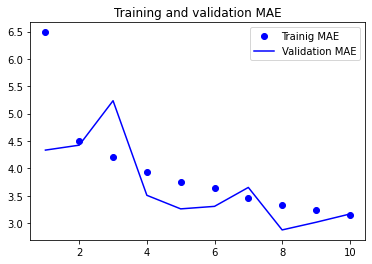

In [43]:
import matplotlib.pyplot as plt
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label='Trainig MAE'  )
plt.plot(epochs, val_loss, "b", label='Validation MAE'  )
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [45]:
# RNN -> 넘파이로 구현
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs =  np.random.random( (timesteps, input_features ) )
state_t = np.zeros( (output_features,) )
W = np.random.random( (output_features, input_features ) )
U = np.random.random( (output_features, output_features ) )
b = np.random.random( (output_features,  ) )
successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis = 0)  

In [46]:
# keras 의 순환층
# RNN 층
num_features = 14
inputs = keras.Input(shape = (None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [47]:
# 마지막 출력 스텝만 반환하는 RNN층
num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = layers.SimpleRNN(16)(inputs)
print(outputs.shape)

(None, 16)


In [48]:
# 전체 출력 시퀀스를 반환하는 RNN 층
num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = layers.SimpleRNN(16,return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [49]:
# 스태킹 RNN층
num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
x = layers.SimpleRNN(16,return_sequences=True)(inputs)
x = layers.SimpleRNN(16,return_sequences=True)(x)
outputs = layers.SimpleRNN(16,)(x)
print(outputs.shape)

(None, 16)


In [50]:
# 순환신경망의 고급 사용법
# 과대적합을 감소하기 위해 순환 드랍아웃
#  드랍아웃규제를 적용한 LSTM 모델 훈련 하고 평가

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data2.shape[-1])  )
x = layers.LSTM(32,recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/10
100/819 [==>...........................] - ETA: 5:09 - loss: 89.2558 - mae: 7.6460

In [ ]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label='Trainig MAE'  )
plt.plot(epochs, val_loss, "b", label='Validation MAE'  )
plt.title("Training and validation MAE")
plt.legend()
plt.show()